<a href="https://colab.research.google.com/github/macroact-lab/robotics-book/blob/main/6_3_q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q-Learning

**Taxi**

There are four designated pick-up and drop-off locations (Red, Green, Yellow and Blue) in the 5x5 grid world. The taxi starts off at a random square and the passenger at one of the designated locations.

The goal is move the taxi to the passenger’s location, pick up the passenger, move to the passenger’s desired destination, and drop off the passenger. Once the passenger is dropped off, the episode ends.

The player receives positive rewards for successfully dropping-off the passenger at the correct location. Negative rewards for incorrect attempts to pick-up/drop-off passenger and for each step where another reward is not received.

Map:

    +---------+
    |R: | : :G|
    | : | : : |
    | : : : : |
    | | : | : |
    |Y| : |B: |
    +---------+

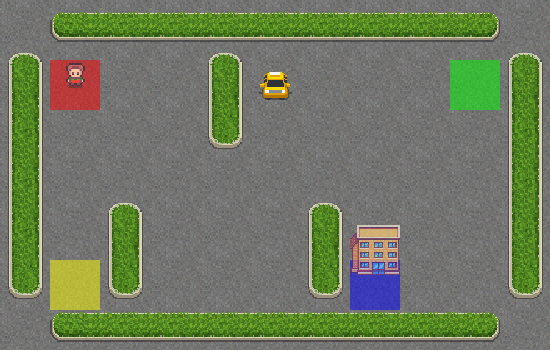

In [ ]:
import gymnasium as gymnasium
import numpy as np
from tqdm import tqdm

In [ ]:
env = gymnasium.make('Taxi-v3', render_mode="rgb_array")
env.metadata['render_fps'] = 30

**Action Space**

The action shape is (1,) in the range {0, 5} indicating which direction to move the taxi or to pickup/drop off passengers.

*   0: Move south (down)
*   1: Move north (up)
*   2: Move east (right)
*   3: Move west (left)
*   4: Pickup passenger
*   5: Drop off passenger







In [ ]:
print("Action Space {}".format(env.action_space))

**Observation Space**

There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations.

Destination on the map are represented with the first letter of the color.

Passenger locations:

*   0: Red
*   1: Green
*   2: Yellow
*   3: Blue
*   4: In taxi

Destinations:

*   0: Red
*   1: Green
*   2: Yellow
*   3: Blue

An observation is returned as an int() that encodes the corresponding state, calculated by ((taxi_row * 5 + taxi_col) * 5 + passenger_location) * 4 + destination

Note that there are 400 states that can actually be reached during an episode. The missing states correspond to situations in which the passenger is at the same location as their destination, as this typically signals the end of an episode. Four additional states can be observed right after a successful episodes, when both the passenger and the taxi are at the destination. This gives a total of 404 reachable discrete states.



In [ ]:
print("Observation Space {}".format(env.observation_space))

**Starting State**

The initial state is sampled uniformly from the possible states where the passenger is neither at their destination nor inside the taxi. There are 300 possible initial states: 25 taxi positions, 4 passenger locations (excluding inside the taxi) and 3 destinations (excluding the passenger’s current location).



**Rewards**

*   -1 per step unless other reward is triggered.
*   +20 delivering passenger.
*   -10 executing “pickup” and “drop-off” actions illegally.

An action that results a noop, like moving into a wall, will incur the time step penalty. Noops can be avoided by sampling the action_mask returned in info.



**Episode End**

The episode ends if the following happens:

Termination: 1. The taxi drops off the passenger.

Truncation (when using the time_limit wrapper): 1. The length of the episode is 200.

In [ ]:
env.reset(seed=123)
env.render()

# Q-agent

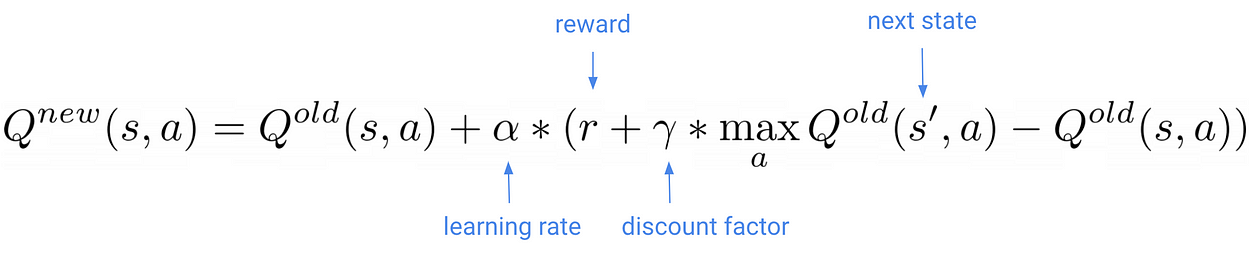

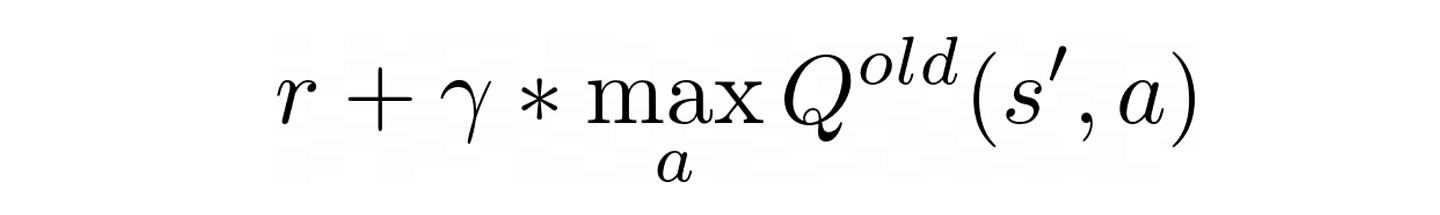

In [ ]:
class QAgent:

    def __init__(self, env, alpha, gamma, epsilon):
        self._env = env

        # q-table: n_states * n_actions
        self._q_table = np.zeros([env.observation_space.n,
                                 env.action_space.n])

        self._alpha = alpha     # learning rate
        self._gamma = gamma     # discount factor
        self._epsilon = epsilon # exploration-exploitation prob

    def get_action(self, obs):
        if np.random.random() < self._epsilon:
            # Explore action space
            return self._env.action_space.sample()
        else:
            # Exploit learned values
            return np.argmax(self._q_table[obs])

    def update_parameters(self, obs, action, reward, next_obs):
        # Q-learning formula
        old_value = self._q_table[obs, action]
        next_max = np.max(self._q_table[next_obs])
        new_value = old_value + self._alpha * (reward + self._gamma * next_max - old_value)

        # update the q_table
        self._q_table[obs, action] = new_value

In [ ]:
# hyperparameters
alpha = 0.1 # learning rate
gamma = 0.6 # discount factor
epsilon = 0.1 # exploration-exploitation prob

agent = QAgent(env, alpha, gamma, epsilon)

In [ ]:
n_episodes = 10000

timesteps_per_episode = []
penalties_per_episode = []


for i in tqdm(range(n_episodes)):

    obs, info = env.reset()

    epochs, penalties, reward, = 0, 0, 0

    done = False
    while not done:

        action = agent.get_action(obs)

        next_obs, reward, terminated, truncated, info = env.step(action)

        agent.update_parameters(obs, action, reward, next_obs)

        if reward == -10:
            penalties += 1

        done = terminated or truncated
        obs = next_obs
        epochs += 1

    timesteps_per_episode.append(epochs)
    penalties_per_episode.append(penalties)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Timesteps to complete ride")
pd.Series(timesteps_per_episode).plot(kind="line")
plt.show()

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Penalties per ride")
pd.Series(penalties_per_episode).plot(kind="line")
plt.show()

In [ ]:
print(f'Avg steps to complete ride: {np.array(timesteps_per_episode).mean()}')
print(f'Avg penalties to complete ride: {np.array(penalties_per_episode).mean()}')

# Evaluation

In [ ]:
!pip install pyvirtualdisplay
!sudo apt-get install -y xvfb ffmpeg
!sudo apt-get install xvfb

In [ ]:
from gymnasium.wrappers import RecordVideo
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

In [ ]:
# Start virtual display
display = Display(visible=0, size=(1400, 900))
display.start()

video_callable=lambda episode_id: True
env = RecordVideo(env, video_folder='./videos', episode_trigger=video_callable)

In [ ]:
obs, info = env.reset(seed=123)

epochs, penalties, reward, = 0, 0, 0

done = False
while not done:

    action = agent.get_action(obs)

    next_obs, reward, terminated, truncated, info = env.step(action)

    if reward == -10:
        penalties += 1

    done = terminated or truncated
    obs = next_obs
    epochs += 1

timesteps_per_episode.append(epochs)
penalties_per_episode.append(penalties)

print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

In [ ]:
# Display the video
video = io.open(glob.glob('videos/*.mp4')[0], 'r+b').read()
encoded = base64.b64encode(video)
ipythondisplay.display(HTML(data='''
    <video width="640" height="480" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4" />
    </video>
'''.format(encoded.decode('ascii'))))